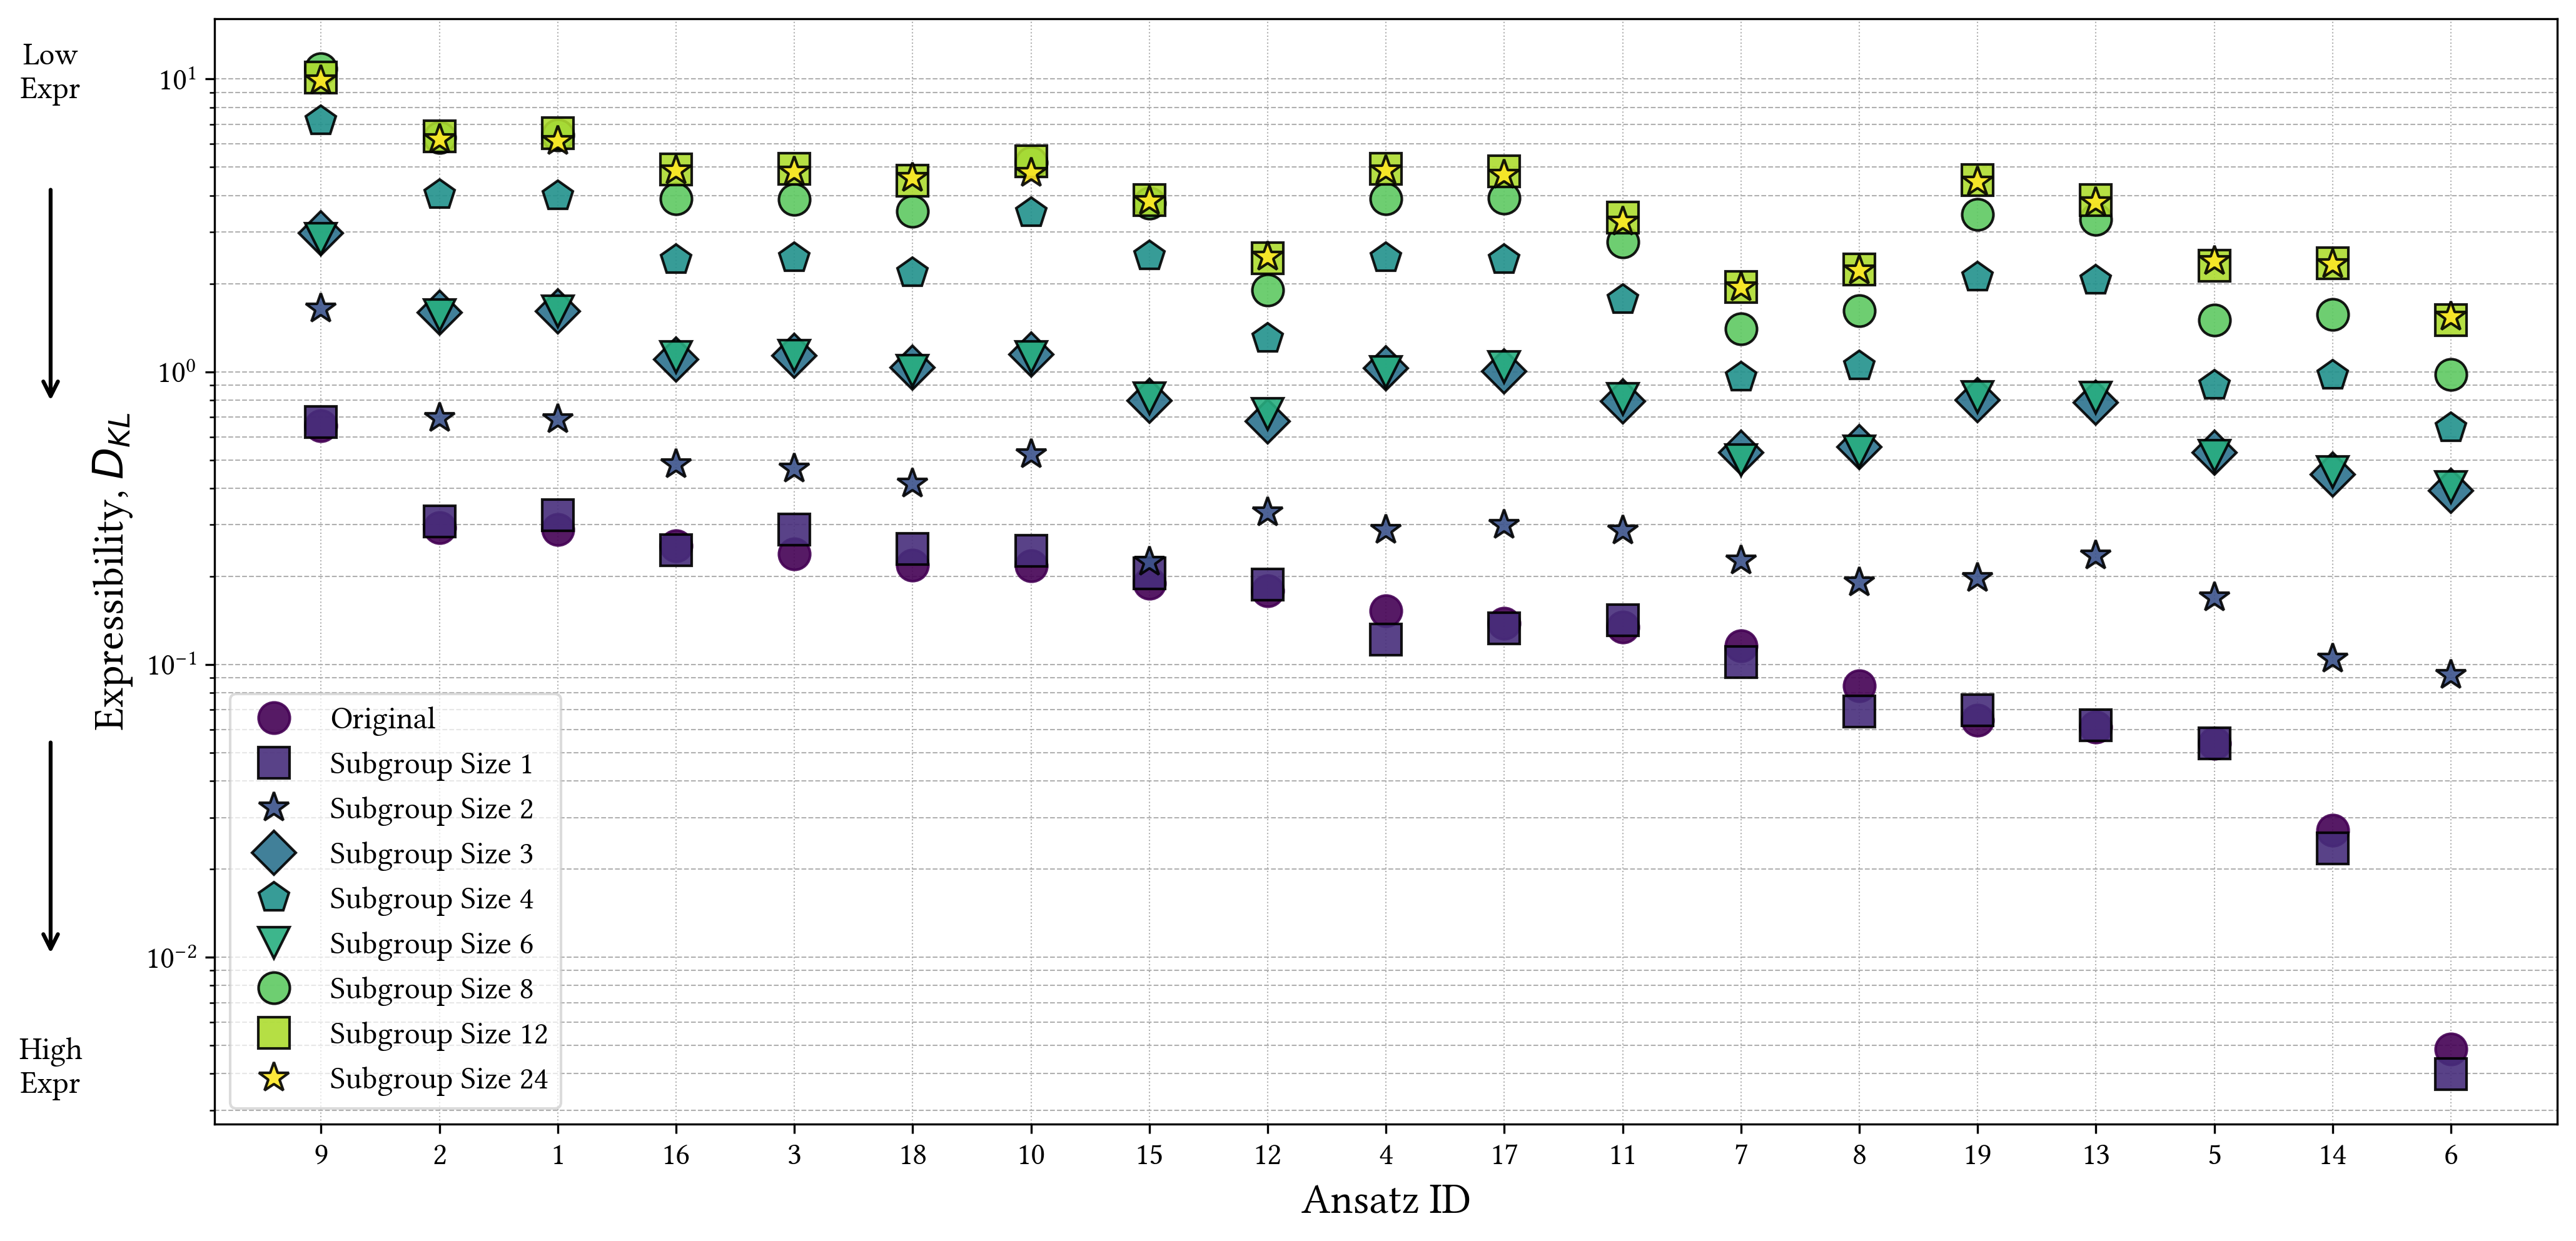

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
# Download all json files from results/expressibility folder into a single data frame
import json
import os

# Load data
data = {}
data_dir = "../results/expressibility"
for filename in os.listdir(data_dir):
    if filename.endswith(".json"):
        with open(os.path.join(data_dir, filename), 'r') as f:
            json_data = json.load(f)
            first_key = next(iter(json_data))
            second_key = next(iter(json_data[first_key]))
            data[(int(first_key), int(second_key))] = json_data[first_key][second_key]

# =============================================================================
# ====== Font configuration (Optional) ========================================
# =============================================================================
# This part is optional if you don't have the "Linux Libertine" font.
# Matplotlib will use a default font if it can't find this one.
try:
    font_path = "C:\\Users\\valte\\OneDrive - University of Helsinki\\Desktop\\linux_libertine\\LinLibertine_R.ttf"
    font_manager.fontManager.addfont(font_path)
    plt.rcParams.update({
        "font.family": "Linux Libertine",
        "font.size": 14,
        "axes.labelsize": 16,
        "axes.titlesize": 18,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
        "figure.dpi": 300,
    })
except FileNotFoundError:
    print("Font not found. Using Matplotlib's default font.")
    plt.rcParams.update({
        "font.size": 12,
        "axes.labelsize": 14,
        "axes.titlesize": 16,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "figure.dpi": 300,
    })


# =============================================================================
# ====== Generate Mock Data ===================================================
# =============================================================================
# This section creates sample data in the format your script expects.
# The data is designed to reproduce the visual trends in the reference figure.
np.random.seed(42)
layer_to_plot = 1
ansatz_ids = list(range(20))
n_qubits = 4
with open(f"../groups/subgroups_{n_qubits}.json", "r") as f:
    subgroups = json.load(f)
subgroups = [int(k) for k in subgroups.keys()]


# =============================================================================
# ====== Extract and Process Data (Corrected) =================================
# =============================================================================
records = []
layer_data = {k[1]: v for k, v in data.items() if k[0] == layer_to_plot}

for ans, ans_data in layer_data.items():
    # **FIX**: Use subgroup=0 as a unique ID for the non-symmetrized case
    records.append({
        "ansatz": int(ans),
        "subgroup": 0,
        "expressibility_mean": ans_data["original"]
    })
    # Add the twirled data
    for subgroup, twirls in ans_data["twirled"].items():
        records.append({
            "ansatz": int(ans),
            "subgroup": int(subgroup),
            "expressibility_mean": np.mean(twirls)
        })

df = pd.DataFrame(records)

# =============================================================================
# ====== Sort Circuits for X-Axis (Corrected) =================================
# =============================================================================
# **FIX**: The sorting is now based ONLY on the original data (subgroup=0)
sorter_df = df[df['subgroup'] == 0].sort_values("expressibility_mean", ascending=False)
sorted_ansatze = sorter_df['ansatz'].tolist()

# **FIX**: Create a robust mapping from ansatz ID to its x-axis position
x_axis_map = {ansatz: i for i, ansatz in enumerate(sorted_ansatze)}

# =============================================================================
# ====== Plotting (Corrected) =================================================
# =============================================================================
fig, ax = plt.subplots(figsize=(14, 7))

# Define markers and colors for each subgroup size
unique_subgroups = sorted(df["subgroup"].unique())
markers = ['o', 's', '*', 'D', 'p', 'v']
colors = plt.cm.viridis(np.linspace(0, 1.0, len(unique_subgroups)))

# Plot data for each subgroup size
for i, subgroup in enumerate(unique_subgroups):
    subset = df[df['subgroup'] == subgroup]
    
    # **FIX**: Use the map to get the correct x-positions for this subgroup's data
    x_positions = [x_axis_map[ans] for ans in subset['ansatz']]
    y_values = subset['expressibility_mean'].values
    
    label = "Original" if subgroup == 0 else f"Subgroup Size {subgroup}"
    
    ax.plot(
        x_positions,
        y_values,
        marker=markers[i % len(markers)],
        linestyle='None',
        label=label,
        color=colors[i],
        markersize=12,
        markeredgecolor='black' if subgroup > 0 else colors[i],
        alpha=0.9
    )

# --- Configure Axes and Labels ---
ax.set_yscale('log')
ax.set_xticks(range(len(sorted_ansatze)))
ax.set_xticklabels(sorted_ansatze, rotation=0)

ax.set_xlabel("Ansatz ID")
ax.set_ylabel("Expressibility, $D_{KL}$")
#ax.set_title(f"Expressibility vs. Circuit ID for Different Subgroup Sizes (Layer {layer_to_plot})")

# --- Add Legend and Grid ---
ax.legend(frameon=True, loc='lower left', facecolor='white', framealpha=0.7)
ax.grid(True, which="both", axis='y', linestyle='--', linewidth=0.5)
ax.grid(True, which="major", axis='x', linestyle=':', linewidth=0.5)

# --- Add Expressibility Direction Arrows ---
ax.annotate('Low\nExpr', xy=(-0.07, 0.95), xycoords='axes fraction', ha='center', va='center', fontsize=12)
ax.annotate('', xy=(-0.07, 0.85), xycoords='axes fraction', xytext=(-0.07, 0.65),
            arrowprops=dict(arrowstyle="<-", lw=1.5, color='black'))

ax.annotate('High\nExpr', xy=(-0.07, 0.05), xycoords='axes fraction', ha='center', va='center', fontsize=12)
ax.annotate('', xy=(-0.07, 0.15), xycoords='axes fraction', xytext=(-0.07, 0.35),
            arrowprops=dict(arrowstyle="->", lw=1.5, color='black'))

plt.tight_layout(pad=1.5)
plt.show()